### Learning LSTM

    Author: 彭日骏
    Time: 2025/10/14

Code a RNN & LSTM to do a **MusicGenerationProject**

---

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_file = 'data/original_metheny.mid'

Using device: cuda


#### Load data


---

**音乐语法化 (Data Representation)**

Through `grammar.py` & `preprocess.py`

Define different notes(音符类型)

`C` (Chord tone)

`S` (Scale tone)

`A` (Approach tone)

`R` (Rest):

`X` (Arbitrary):

**Token的格式:** (类型, 时值, 与上一个音符的音程)

已知Tokens total = 78 *(不知道为什么事实上我做出来 155)*

**序列化与数据准备 (Sequence Modeling)**

Through `preprocess.py` & `music_utils.py` generate

`Corpus(语料库)`: A long sequence contains all **Tokens**

`Training dataset(训练集)`: 切分sequence为多个 Tx = 30 的序列X

`Label dataset(标签集)`: 等效序列X向后平移一位得到Y,  $Y = (x_{1}, x_{2}, ..., x_{n}, x_{n+1})$ 去掉 $x_{0}$

`One-Hot 编码`: 长成78维向量，对应Token的向量为对应位置1

已知X = (1428, 30, 155) , 被切成: 1428个片段, 每个片段长30个Tokens, 每个Token对应78维向量

---

##### 熟悉data

mid文件到底有几个轨道，分别有多少个不同的对象

---

In [2]:
from data_utils import check_data

check_data(data_file)


--- 自动化轨道检查 ---
文件总共有 19 个轨道 (Parts)。

--- 轨道 0 ('midi_data[0]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCore', 'Music21Object', 'ProtoM21Object', 'Generic', 'object')
  找到 'stream.Voice' 对象的数量: 0, 轨道0

--- 轨道 1 ('midi_data[1]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCore', 'Music21Object', 'ProtoM21Object', 'Generic', 'object')
  找到 'stream.Voice' 对象的数量: 0, 轨道1

--- 轨道 2 ('midi_data[2]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCore', 'Music21Object', 'ProtoM21Object', 'Generic', 'object')
  找到 'stream.Voice' 对象的数量: 0, 轨道2

--- 轨道 3 ('midi_data[3]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCore', 'Music21Object', 'ProtoM21Object', 'Generic', 'object')
  找到 'stream.Voice' 对象的数量: 0, 轨道3

--- 轨道 4 ('midi_data[4]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCore', 'Music21Object', 'ProtoM21Object', 'Generic', 'object')
  找到 'stream.Voice' 对象的数量: 0, 轨道4

--- 轨道 5 ('midi_data[5]') ---
  乐器: None
  包含的元素类型: ('Part', 'Stream', 'StreamCo

---

##### 数据载入

改变ORIGINAL_MELODY_INDEX, ORIGINAL_ACCOMP_INDICES 调整需要阅读的轨道

---

In [3]:
import numpy as np
from preprocess import get_musical_data, get_corpus_data

ORIGINAL_MELODY_INDEX = 5
ORIGINAL_ACCOMP_INDICES = [0, 1, 6]# 7

chords, abstract_grammars = get_musical_data(
            data_file, 
            melody_part_index=ORIGINAL_MELODY_INDEX, 
            accompaniment_part_indices=ORIGINAL_ACCOMP_INDICES
        )
        
if abstract_grammars:
    print("\n--- 成功！---")
    print(f"返回的 'chords_for_playback' 中的元素数量: {len(chords)}")
    print(f"生成的 'abstract_grammars' 的小节数: {len(abstract_grammars)}")
    
    # 2. 执行语料库生成
    corpus, values, val_indices, indices_val = get_corpus_data(abstract_grammars)
    
    if corpus:
        print("\n--- 成功！---")
        print(f"第一个语法 token: {corpus[0]}")
        print(f"最后一个语法 token: {corpus[-1]}")
        print(f"Token '{corpus[0]}' 对应的索引: {val_indices[corpus[0]]}")

# Tokens dic total length
n_values = len(values)

正在从 'data/original_metheny.mid' 加载 MIDI 文件...
正在从轨道 5 提取旋律...
正在从轨道 [0, 1, 6] 提取伴奏 (用于播放)...
正在对整个乐曲进行和弦分析 (chordify)...
正在将旋律和和弦按小节对齐...
正在逐小节生成语法 (共 217 个小节)...
在处理小节 0 时出错: attempting to access index 0 while elements is of size 0
在处理小节 4 时出错: attempting to access index 0 while elements is of size 0
在处理小节 9 时出错: attempting to access index 0 while elements is of size 0
在处理小节 10 时出错: attempting to access index 0 while elements is of size 0
在处理小节 19 时出错: attempting to access index 0 while elements is of size 0
在处理小节 20 时出错: attempting to access index 0 while elements is of size 0
语法生成完毕。

--- 成功！---
返回的 'chords_for_playback' 中的元素数量: 3126
生成的 'abstract_grammars' 的小节数: 211
正在从抽象语法创建语料库和词典...
语料库创建完成。Token 总数: 1458, 独立词汇表大小: 155

--- 成功！---
第一个语法 token: R,4.000
最后一个语法 token: C,0.250,<m2,P-4>
Token 'R,4.000' 对应的索引: 76


In [4]:
n_values

155

In [5]:
def create_dataset(corpus, val_indices, n_values, Tx, step):
    """
    Windows to cut sequences

    Parameters:
    corpus(list): contains all tokens list
    val_indices(dict): token -> index
    n_values(int): dictionary_size
    Tx(int): windows length
    step(int): windows step

    Return:
    X_tensor(torch.Tensor): One-Hot input (num_samples, Tx, n_values) 
    Y_tensor(torch.Tensor): label output (num_samples, Tx)
    """

    corpus_indices = [val_indices[token] for token in corpus]

    sequences_X_indices = []
    sequences_Y_indices = []

    for i in range(0, len(corpus_indices) - Tx, step):
        # X_tensor
        in_seq = corpus_indices[i : i + Tx]
        # Y_tensor
        out_seq = corpus_indices[i + 1 : i + Tx + 1]

        sequences_X_indices.append(in_seq)
        sequences_Y_indices.append(out_seq)

    num_samples = len(sequences_X_indices)
    
    X_indices_np = np.array(sequences_X_indices)
    Y_indices_np = np.array(sequences_Y_indices)

    # one-hot to X
    X_onehot_np = np.zeros((num_samples, Tx, n_values), dtype=np.float32)
    batch_idx = np.arange(num_samples).reshape(-1, 1)
    time_idx = np.arange(Tx).reshape(1, -1)
    val_idx = X_indices_np
    X_onehot_np[batch_idx, time_idx, val_idx] = 1.0

    X_tensor = torch.tensor(X_onehot_np, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_indices_np, dtype=torch.long) # CrossEntropyLoss needs long type

    return X_tensor, Y_tensor

In [6]:
Tx = 300
step = 1
batch_size = 64

X, Y = create_dataset(corpus, val_indices, n_values, Tx=Tx, step=step)

print(X.shape)
print(Y.shape)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)


torch.Size([1158, 300, 155])
torch.Size([1158, 300])


#### Model structure

---

In [7]:
class DeepJazzPyTorch(nn.Module):
    """
    Def LSTM
    """
    def __init__(self, n_values=155, n_a=64):
        """
        Parameters:
        n_values: Tokens long
        n_a: hidden_layers_size
        """
        super(DeepJazzPyTorch, self).__init__()
        
        self.n_values = n_values
        self.n_a = n_a

        self.lstm_cell = nn.LSTMCell(input_size=n_values, hidden_size=n_a)

        self.densor = nn.Linear(in_features=n_a, out_features=n_values)

    def forward(self, X, a0=None, c0=None):
        """
        Parameters:
        X (torch.Tensor): (batch_size, Tx, n_values)
        a0 (torch.Tensor): initial hidden layer (batch_size, n_a)
        c0 (torch.Tensor): initial cell status (batch_size, n_a)
        
        Return:
        outputs (torch.Tensor): 所有时间步的输出 logits，形状为 (batch_size, Tx, n_values)
        """
        
        # 获取批次大小和序列长度
        batch_size, Tx, _ = X.shape
        
        # 初始化隐藏状态和细胞状态
        if a0 is None and c0 is None:
            a = torch.zeros(batch_size, self.n_a, device=X.device)
            c = torch.zeros(batch_size, self.n_a, device=X.device)
        else:
            a, c = a0, c0
            
        # 存储每一步的输出
        outputs = []

        for t in range(Tx):
            # 从 X 中获取当前时间步的输入
            # X: (batch_size, Tx, n_values)
            x = X[:, t, :]

            # 运行 LSTM 单元一步
            a, c = self.lstm_cell(x, (a, c))

            # 用全连接层计算输出 logits
            out = self.densor(a) # 形状: (batch_size, n_values)
            
            outputs.append(out)
            
        # 将 list of (batch_size, n_values) 堆叠成 (batch_size, Tx, n_values)
        # 这对于计算损失函数很方便
        outputs_tensor = torch.stack(outputs, dim=1)
        
        return outputs_tensor

    def generate(self, x0, a0=None, c0=None, Ty=100, temperature=1.0):
        """
        Parameters:
        x0 (torch.Tensor): (batch_size, n_values)---起始音节
        X (torch.Tensor): (batch_size, Tx, n_values)
        a0 (torch.Tensor): initial hidden layer (batch_size, n_a)
        c0 (torch.Tensor): initial cell status (batch_size, n_a)
        Ty (int): 要生成的时间步数量
        temperature(float): 采样温度 0.0 = argmax, >0 = 随机采样
        
        Return: 
        generated_indices (torch.Tensor): 生成的 token 索引，形状 (batch_size, Ty)
        """

        batch_size, _ = x0.shape
        
        # 1. 初始化状态 (同 forward)
        if a0 is None and c0 is None:
            a = torch.zeros(batch_size, self.n_a, device=x0.device)
            c = torch.zeros(batch_size, self.n_a, device=x0.device)
        else:
            a, c = a0, c0
            
        # 初始输入
        x = x0
        
        # 存储生成的 token 索引
        generated_indices = []
        
        for t in range(Ty):
            # 运行 LSTM 单元一步
            a, c = self.lstm_cell(x, (a, c))
            
            # 计算输出 logits
            out = self.densor(a) # (batch_size, n_values)
            
            if temperature == 0.0:
                next_token_idx = torch.argmax(out, dim=1)
            else:
                logits_with_temp = out / temperature
                probs = F.softmax(logits_with_temp, dim=1)

                next_token_idx = torch.multinomial(probs, num_samples=1)
                next_token_idx = next_token_idx.squeeze(1)
            # 存储这个索引
            generated_indices.append(next_token_idx)
            
            # 将索引转换回 One-Hot 向量，作为下一步的输入
            x = F.one_hot(next_token_idx, num_classes=self.n_values).float()

        # 堆叠所有生成的索引
        # list of (batch_size,) 堆叠成 (batch_size, Ty)
        generated_indices_tensor = torch.stack(generated_indices, dim=1)
        
        return generated_indices_tensor

n_values = 155
n_a = 64
model = DeepJazzPyTorch(n_values=n_values, n_a=n_a).to(device)

In [8]:
# Keras X: (1428, 30, 155), Keras Y: (1428, 30, 155) list
# PyTorch X: (60, 30, 78)
# PyTorch Y (logits): (60, 30, 78)
# PyTorch Y (indices): (60, 30)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

epochs = 100
train_losses = [] # 可视化模型Loss，观察收敛效果

model.train()

for i in range(epochs):
    epoch_loss = 0.0

    for seq, labels in dataloader:
        seq, labels = seq.to(device), labels.to(device)

        Y_pred_logits = model(seq)

        loss = criterion(Y_pred_logits.reshape(-1, n_values), labels.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_epoch_loss)

    if (i+1) % 10 ==0:
        print(f'Epoch: {i+1:3d}/{epochs}, Loss: {avg_epoch_loss:.6f}')

print("训练完成!")

Epoch:  10/100, Loss: 0.400606
Epoch:  20/100, Loss: 0.071240
Epoch:  30/100, Loss: 0.038809
Epoch:  40/100, Loss: 0.029722
Epoch:  50/100, Loss: 0.023548
Epoch:  60/100, Loss: 0.020540
Epoch:  70/100, Loss: 0.018487
Epoch:  80/100, Loss: 0.018021
Epoch:  90/100, Loss: 0.016351
Epoch: 100/100, Loss: 0.015021
训练完成!


In [9]:
SAVE_PATH = "generate_music_model.pth"

torch.save(model.state_dict(), SAVE_PATH)

print(f"模型权重已成功保存到: {SAVE_PATH}")

模型权重已成功保存到: generate_music_model.pth


#### 训练过程Loss可视化

---

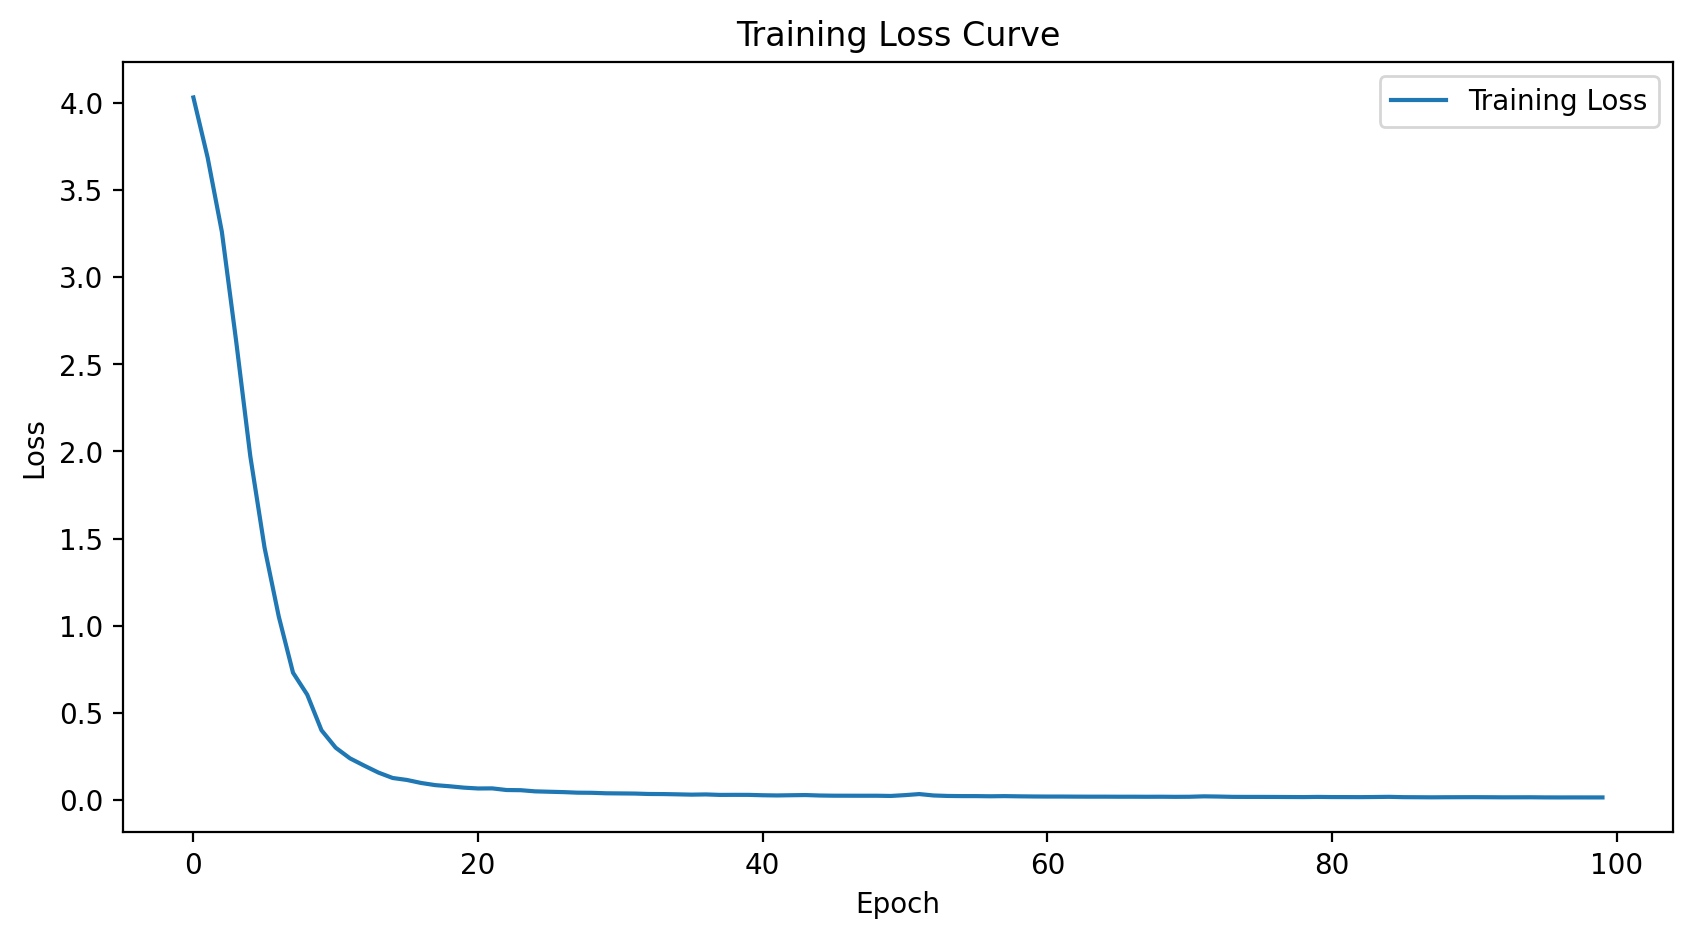

In [10]:
# Loss收敛过程可视化
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

好像有些过拟合了，目视训练大概100 epoch就够了，重新训练一个100轮左右的

---

#### Generate Music

---

In [14]:
model.load_state_dict(torch.load("generate_music_model.pth")) # 加载模型

from data_utils import generate_music

out_stream = generate_music(
    model=model,
    indices_val=indices_val,
    original_chords_stream=chords,
    n_values=n_values,
    n_a=n_a,
    Ty_per_measure=300,  # 为每个小节生成 300 个 token
    temperature=0.0,    # 0.0 = 确定性 (argmax)， > 0 = 随机性
    device=device
)
    
if out_stream:
    print("音乐流对象已生成。")
else:
    print("错误：未找到 'model', 'indices_val' 或 'chords_for_playback'。")
    print("请确保在调用生成函数前已加载数据和模型。")

开始生成音乐...
伴奏已切分为 217 个小节。
警告：在小节 0 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 1/217: 生成了 0 个音符事件。
警告：在小节 1 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 2/217: 生成了 0 个音符事件。
警告：在小节 2 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 3/217: 生成了 0 个音符事件。
警告：在小节 3 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 4/217: 生成了 0 个音符事件。
警告：在小节 4 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 5/217: 生成了 0 个音符事件。
警告：在小节 5 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 6/217: 生成了 0 个音符事件。
警告：在小节 6 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 7/217: 生成了 0 个音符事件。
小节 8/217: 生成了 278 个音符事件。
警告：在小节 8 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 9/217: 生成了 0 个音符事件。
警告：在小节 9 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 10/217: 生成了 0 个音符事件。
警告：在小节 10 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 11/217: 生成了 0 个音符事件。
警告：在小节 11 反解析语法时出错: Cannot choose from an empty sequence。跳过此小节。
小节 12/217: 生成了 0 个音符事件

In [12]:
out_stream.show('midi')

---

#### 常用LSTM架构 *（不同于上述LSTMcell架构）*

---

In [13]:
# # LSTM Model
# class temp_predict_LSTM(nn.Module):
#     def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
#         '''
#         Def LSTM layer
#         Parameters:
#             input_size: num of features for the input sequence（输入特征的数量），只需要预测温度一个特征
#             hidden_layer_size
#             batch_first 
#                         let Tensor turn to (batch_size, seq_length, input_size)
#         '''
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
#         # Change!!!
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
#         self.linear = nn.Linear(hidden_layer_size, output_size)

#     def forward(self, input_seq):
#         '''
#         Forward Algorithm
#         LSTM need 2 of origin status hidden_layer h0 & cell_layer c0
#         '''
#         # LSTM需要初始化隐藏状态h_0 = (num_layers, batch_size, hidden_size)
#         # LSTM需要初始化隐藏状态c_0 = (num_layers, batch_size, hidden_size)
#         # 且我们需要把h0, c0移植至device
#         h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
#         c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

#         # lstm_out 是所有时间步的输出
#         # lstm_out 为常用Tensor张量(batch_size, seq_length, input_size) ---???为何这样处理数据更简便
#         # hidden 是最后一个时间步的隐藏状态
#         lstm_out, hidden = self.lstm(input_seq, h0)

#         # 只关心序列最后一个时间步的输出
#         # lstm[:, -1, :]可丢弃掉中间维度seq_length, 变为二维Tensor张量(batch_size, hidden_size)
#         predictions = self.linear(lstm_out[:, -1, :])

#         return predictions

---